In [14]:
import lzma
import pandas as pd
from io import BytesIO
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:

DATA_PATH = Path('./SARS-CoV-2-Sequenzdaten_aus_Deutschland')

# LINEAGE_COL = 'lineage'
LINEAGE_COL = 'scorpio_call'
# [x for x in p.iterdir()]

# Load Data

In [4]:
def load_all_data(DATA_PATH):
    """ Loads the two files and returns as dataframes """

    fname_lines = 'SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz'
    fname_seq = 'SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz'

    fpath_lines = DATA_PATH.joinpath(fname_lines)
    fpath_seq = DATA_PATH.joinpath(fname_seq)

    def load_file(fpath):
        # Read file, decompress, save as bytes string
        fbytes_str = lzma.open(fpath).read()
        # Convert byte string to pandas df
        df = pd.read_csv(BytesIO(fbytes_str))
        return df

    dflines = load_file(fpath_lines)
    dfseq = load_file(fpath_seq)

    return dflines, dfseq

dflines, dfseq = load_all_data(DATA_PATH)


In [5]:
dflines.head(2)

,IMS_ID,lineage,conflict,ambiguity_score,scorpio_call,scorpio_support,scorpio_conflict,version,pangolin_version,pangoLEARN_version,pango_version,status,note
0,IMS-10025-CVDP-00009,B.1.1.7,NaN,NaN,Alpha (B.1.1.7-like),0.9565,0.0435,PANGO-v1.2.105,3.1.17,2021-12-06,v1.2.105,passed_qc,scorpio call: Alt alleles 22; Ref alleles 1; A...
1,IMS-10294-CVDP-00323,B.1.160,NaN,NaN,NaN,NaN,NaN,PANGO-v1.2.105,3.1.17,2021-12-06,v1.2.105,passed_qc,Assigned from designation hash.


In [6]:
dflines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401937 entries, 0 to 401936
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   IMS_ID              401937 non-null  object 
 1   lineage             401937 non-null  object 
 2   conflict            339739 non-null  float64
 3   ambiguity_score     339739 non-null  float64
 4   scorpio_call        367714 non-null  object 
 5   scorpio_support     367714 non-null  float64
 6   scorpio_conflict    367714 non-null  float64
 7   version             401937 non-null  object 
 8   pangolin_version    401937 non-null  object 
 9   pangoLEARN_version  401937 non-null  object 
 10  pango_version       401937 non-null  object 
 11  status              401937 non-null  object 
 12  note                369557 non-null  object 
dtypes: float64(4), object(9)
memory usage: 39.9+ MB


In [7]:
dfseq.head()

,IMS_ID,DATE_DRAW,SEQ_TYPE,SEQ_REASON,SAMPLE_TYPE,OWN_FASTA_ID,RECEIVE_DATE,PROCESSING_DATE,SENDING_LAB_PC,SEQUENCING_LAB_PC
0,IMS-10294-CVDP-00001,2021-01-14,ILLUMINA,X,S002,NaN,2021-01-25,2021-01-25,40225.0,40225.0
1,IMS-10294-CVDP-00002,2021-01-14,ILLUMINA,X,S002,NaN,2021-01-25,2021-01-25,40225.0,40225.0
2,IMS-10025-CVDP-00001,2021-01-17,ION_TORRENT,N,S002,NaN,2021-01-26,2021-01-26,10409.0,10409.0
3,IMS-10025-CVDP-00002,2021-01-17,ION_TORRENT,N,S002,NaN,2021-01-26,2021-01-26,10409.0,10409.0
4,IMS-10025-CVDP-00003,2021-01-17,ION_TORRENT,N,S002,NaN,2021-01-26,2021-01-26,10409.0,10409.0


In [8]:
dflines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401937 entries, 0 to 401936
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   IMS_ID              401937 non-null  object 
 1   lineage             401937 non-null  object 
 2   conflict            339739 non-null  float64
 3   ambiguity_score     339739 non-null  float64
 4   scorpio_call        367714 non-null  object 
 5   scorpio_support     367714 non-null  float64
 6   scorpio_conflict    367714 non-null  float64
 7   version             401937 non-null  object 
 8   pangolin_version    401937 non-null  object 
 9   pangoLEARN_version  401937 non-null  object 
 10  pango_version       401937 non-null  object 
 11  status              401937 non-null  object 
 12  note                369557 non-null  object 
dtypes: float64(4), object(9)
memory usage: 39.9+ MB


In [9]:
dfseq['SEQ_REASON'].value_counts()

N                      167836
X                      139165
A[B.1.1.7]              34675
A[B.1.617.2]            26293
Y                       25187
                        ...  
A[25.12.1982]               1
A[16.09.1956]               1
A[KAPPA]                    1
A[UNKLAR]                   1
A[L452R,HV69/70DEL]         1
Name: SEQ_REASON, Length: 183, dtype: int64

# Data processing

In [10]:
def merge_data(dflines, dfseq):
    df = pd.merge(dflines, dfseq, how='inner', on='IMS_ID')

    # Performs some processing
    df['date'] = pd.to_datetime(df['DATE_DRAW'])
    df['count'] = 1 # used as counter in groupbys
    # Select only columns of interest
    df = df[['IMS_ID', 'date', 'lineage', 'SEQ_REASON', 'scorpio_call', 'count']]

    #  Replace some of the lineage names with general lineages
    replacements = {
        'Delta (B.1.617.2-like)': 'Delta',
        'Delta (AY.4-like)': 'Delta',
        'Delta (AY.4.2-like)': 'Delta',
        'Delta (B.1.617.2-like) +K417N': 'Delta',
        'Omicron (BA.1-like)': 'Omicron',
        'Probable Omicron (BA.1-like)': 'Omicron',
        'Probable Omicron (B.1.1.529-like)': 'Omicron',
    }
    df = df.replace({'scorpio_call': replacements})
    return df


df = merge_data(dflines, dfseq)
df.head()

,IMS_ID,date,lineage,SEQ_REASON,scorpio_call,count
0,IMS-10025-CVDP-00009,2021-01-18,B.1.1.7,N,Alpha (B.1.1.7-like),1
1,IMS-10294-CVDP-00323,2020-12-16,B.1.160,X,NaN,1
2,IMS-10294-CVDP-00321,2020-12-16,B.1.221,X,NaN,1
3,IMS-10294-CVDP-00320,2020-12-16,C.35,X,NaN,1
4,IMS-10294-CVDP-00319,2020-12-16,B.1.177.62,X,NaN,1


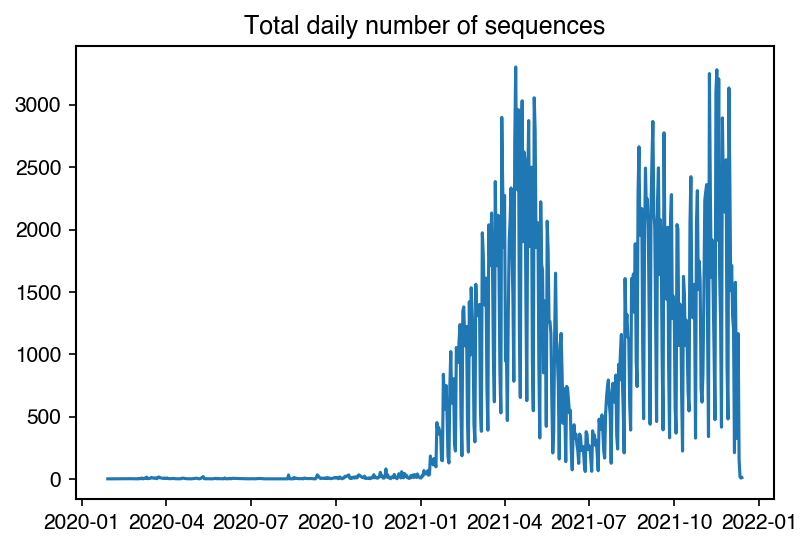

In [11]:
# Calculate daily number of lineages
n_seq_daily = df.groupby(by='date').count()['count'].reset_index()
plt.plot(n_seq_daily['date'], n_seq_daily['count'])
plt.title("Total daily number of sequences")
plt.show()

In [12]:
def count_lineages(df, seq_reason='any'):
    """ Count the daily numbers of lineages

    Parameters:
    -----------
     - seq_reason: str
        Filter for the reason why sequences was taken,
        see documentation
        Options:
         - 'random': only random sampling
         - 'any': any value 
    """

    assert(seq_reason in ['random', 'any'])

    # Filter if randomly sampled chosen, otherwise do no filtering
    if seq_reason == 'random':
        df = df.loc[df['SEQ_REASON']=='N']

    if LINEAGE_COL == 'scorpio_call':
        df = df.dropna(axis=0, subset=['scorpio_call'])

    # Calculate daily number of lineages
    n_seq_daily = df.groupby(by='date').count()['count'].reset_index()

    # Count the daily number of each lineage
    lin_daily = df.groupby(by=[LINEAGE_COL, 'date']).count()['count'].reset_index()

    # Merge lineage and total numbers
    lin_daily = pd.merge(lin_daily, n_seq_daily, on='date', how='inner', suffixes=('_lin', '_total'))

    # Calc fraction of variant
    lin_daily['relative_lin'] = lin_daily['count_lin'] / lin_daily['count_total']

    lin_daily = lin_daily.sort_values(by=[LINEAGE_COL, 'date'])
    return lin_daily

lin_daily = count_lineages(df, seq_reason='any')
lin_daily.head()

,scorpio_call,date,count_lin,count_total,relative_lin
0,A.23.1-like,2021-02-12,1,528,0.001894
5,A.23.1-like,2021-02-22,1,686,0.001458
10,A.23.1-like,2021-02-24,2,923,0.002167
16,A.23.1-like,2021-02-25,1,669,0.001495
23,A.23.1-like,2021-02-28,3,190,0.015789


# Analysis

### Utility functions

In [13]:
def get_top_n_lineages(df, n):
    """ Return list of n lineages with most sequences """
    li = list(df[LINEAGE_COL].value_counts().head(n).index)
    # Add Delta and Omicron at the top
    while 'Delta' in li: li.remove('Delta')
    while 'Omicron' in li: li.remove('Omicron')
    li = ['Delta', 'Omicron'] + li
    return li  

def get_handpicked_lineages():
    return [
        'Delta',
        'Omicron'
    ]
    
lineages = get_top_n_lineages(lin_daily, n=10)

### Plotting functions

In [16]:
def plot_lineages_absolute(lin_daily, n=10, date_range=('2021-05-01','2021-12-20')):
    """ Plot the daily total count of each lineage 
    
    Parameters:
     - n: int
        Plot the n lineages with the most count
    """
    lineages = get_top_n_lineages(lin_daily, n)
    # lineages = get_handpicked_lineages()

    for lin in lineages:
        lineage = lin_daily.loc[lin_daily[LINEAGE_COL]==lin]

        # Fill missing dates with 0
        idx = pd.date_range(min(lineage['date']), max(lineage['date']))
        # idx = pd.date_range(date_range[0], datetime.today())
        lineage = lineage.set_index('date').reindex(idx, fill_value=0).reset_index()

        plt.plot(lineage['index'], lineage['count_lin'], label=lin, lw=1)

    plt.ylabel("number of sequences")
    plt.xlim(date_range)
    plt.legend(fontsize=6)
    plt.xticks(rotation=45)

In [17]:
def plot_lineages_relative(lin_daily, n=10, date_range=('2021-05-01','2021-12-20')):
    """ Plot the daily fraction of each lineage 
    
    Parameters:
     - n: int
        Plot the n lineages with the most count
    """

    lineages = get_top_n_lineages(lin_daily, n)
    # lineages = get_handpicked_lineages()

    for i, lin in enumerate(lineages):
        lineage = lin_daily.loc[lin_daily[LINEAGE_COL]==lin]

        # Fill missing dates with 0
        idx = pd.date_range(min(lineage['date']), max(lineage['date']))
        # idx = pd.date_range(date_range)
        lineage = lineage.set_index('date').reindex(idx, fill_value=0).reset_index()
        plt.plot(lineage['index'], lineage['relative_lin'], label=lin, lw=1, zorder=-i)

    plt.ylabel("fraction of sequences")
    plt.xlim(date_range)
    plt.legend(fontsize=6)
    plt.xticks(rotation=45)

## Analysis

In [18]:
date_range=('2021-05-01','2021-12-20')
# Number of sequences to plot
n = 10

### All sequences

Lineages with any sequencing reason

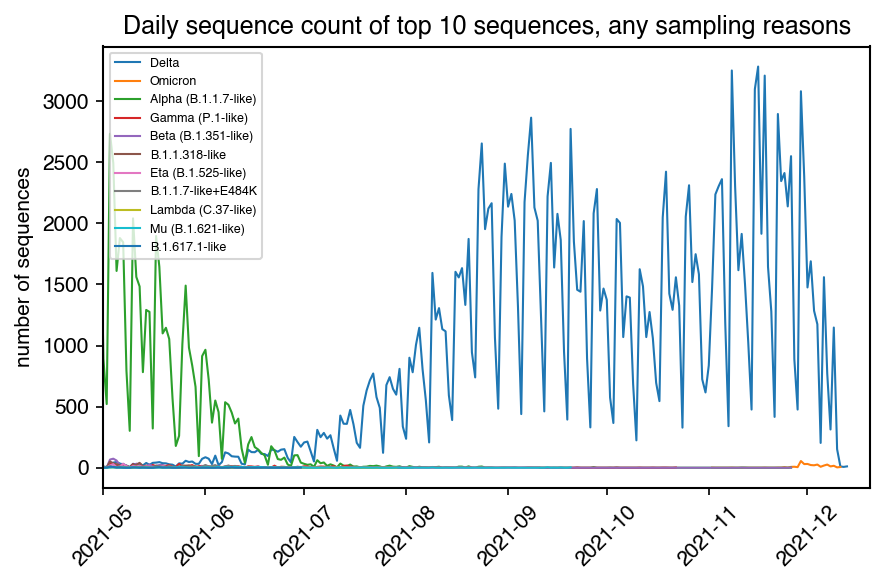

In [19]:
lin_daily = count_lineages(df, seq_reason='any')

plot_lineages_absolute(lin_daily, n, date_range)
plt.title(f"Daily sequence count of top {n} sequences, any sampling reasons")
plt.tight_layout()
plt.savefig("./output/sequences_absolute_any_sampling.pdf")
plt.show()

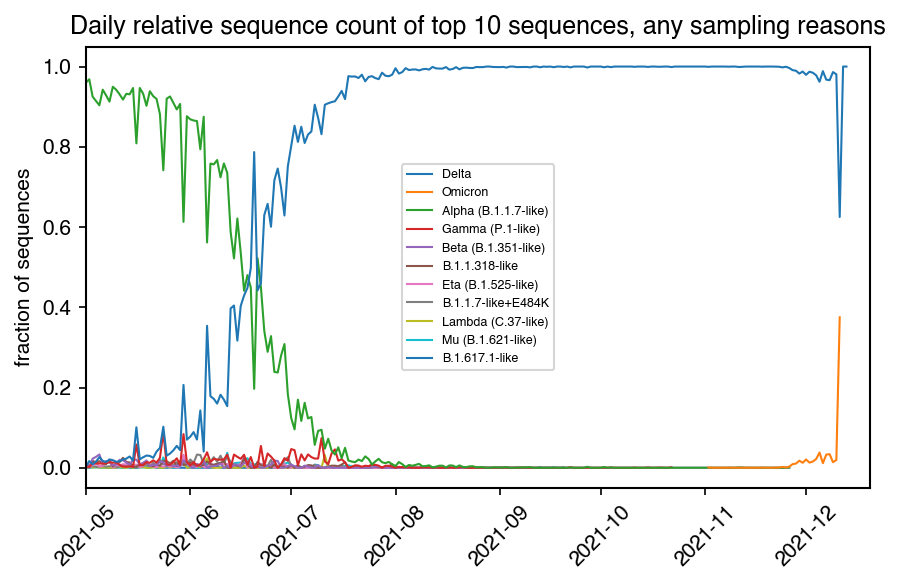

In [20]:
plot_lineages_relative(lin_daily, n, date_range)
plt.title(f"Daily relative sequence count of top {n} sequences, any sampling reasons")
plt.tight_layout()
plt.savefig("./output/sequences_relative_any_sampling.pdf")
plt.show()

### Only random samples

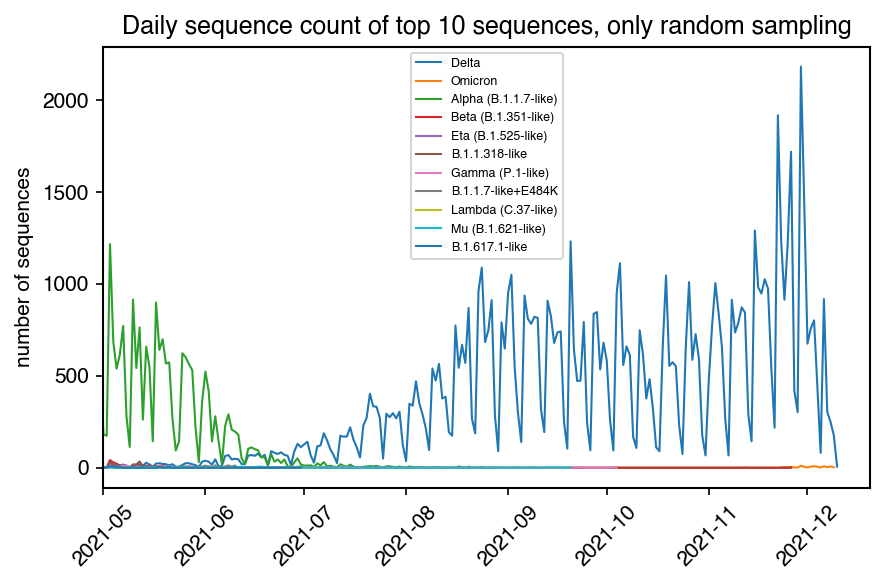

In [21]:
lin_daily = count_lineages(df, seq_reason='random')

plot_lineages_absolute(lin_daily, n, date_range)
plt.title(f"Daily sequence count of top {n} sequences, only random sampling")
plt.tight_layout()
plt.savefig("./output/sequences_absolute_random_sampling.pdf")
plt.show()

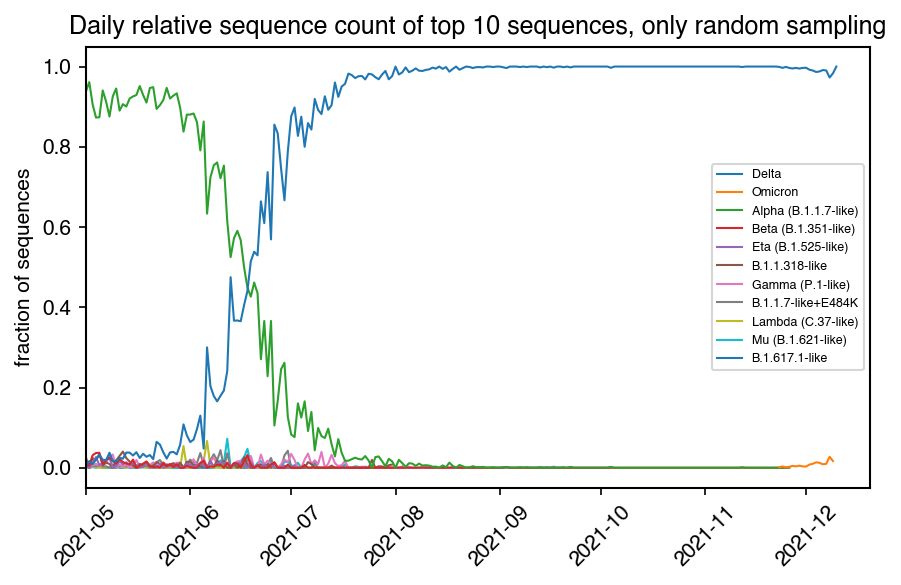

In [22]:
plot_lineages_relative(lin_daily, n, date_range)
plt.title(f"Daily relative sequence count of top {n} sequences, only random sampling")
plt.tight_layout()
plt.savefig("./output/sequences_relative_random_sampling.pdf")
plt.show()